## Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 
import random
import time
import pandas as pd
import ast 
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Mounted at /content/drive/


In [2]:
data = pd.read_csv('/content/drive/My Drive/Root/Ressources/tunisia.csv')
data.head(2)

,id,level,rating,rating_local,quadkey,location,bounding_box,name,name_suffix,name_local,name_en,name_translated,url,duration_estimate,marker,class,categories,tag_keys,parents,perex,customer_rating,hotel_star_rating,hotel_star_rating_unofficial,thumbnail_url
0,poi:12785108,poi,0.004367,0.021835,122001332303232011000,"{'lat': 36.747554, 'lng': 10.3093012}",NaN,UBCI,"Ben Arous, Tunisia",UBCI,NaN,NaN,https://go.sygic.com/travel/place?id=poi:12785108,900,other-bank,"{'slug': 'other:bank', 'name': 'Bank'}",[],['Bank'],"[{'id': 'city:887945', 'name': 'Ezzahra', 'lev...",NaN,NaN,NaN,NaN,https://media-cdn.sygictraveldata.com/media/po...
1,poi:34628663,poi,0.003982,0.019912,122003111030000213002,"{'lat': 36.4508796, 'lng': 10.726897}","{'south': 36.450804, 'west': 10.7268058, 'nort...",Banque Zitouna,"Nabeul, Tunisia",Zitouna,Banque Zitouna,Banque Zitouna,https://go.sygic.com/travel/place?id=poi:34628663,900,other-bank,"{'slug': 'other:bank', 'name': 'Bank'}",[],['Bank'],"[{'id': 'city:10162', 'name': 'Nabeul', 'level...",Banque Zitouna is the first Islamic bank in Tu...,NaN,NaN,NaN,https://media-cdn.sygictraveldata.com/media/po...


In [3]:
def clean_features(data):
  lst = ['id', 'location', 'name', 'name_suffix', 'categories', 'tag_keys']
  return data[lst]

def clean_location(data):
    df3 = data.copy()
    lat = []
    lng = []
    for index, row in df3.iterrows():
      d = ast.literal_eval(row['location'])
      lat.append(d['lat'])
      lng.append(d['lng'])

    #print(len(lat),len(lng))
    df3['lat'] = lat
    df3['lng'] = lng
    df3.drop('location',axis = 1, inplace=True)
    return df3

def find_Tunis_pois(df):
  regions = ['Ben Arous', 'Aryanah', 'Carthage', 'Twns', 'Tunis', 'Manouba', 
           'Medina of Tunis', 'La Goulette', 'Hy alkhdra Az Zuhoor']
  res = []
  geo = df.copy()
  for index,row in geo.iterrows():
    current = row['name_suffix'].split(',')
    yes = False
    for r in regions:
      if r in current:
        yes = True
        break
    
    if yes:
      name = row['name']
      suffix = row['name_suffix']
      lat = row['lat']
      lng = row['lng']
      index = row['id']
      tags = row['categories'] +', '+row['tag_keys']
      res.append({'id':index,'name':name,'suffix':suffix,'lat':lat,'lng':lng,'tags':tags})
  vis = pd.DataFrame(res)
  return vis

def preprocessing(data):
  df = clean_features(data)
  df = clean_location(df)
  df = find_Tunis_pois(df)
  df.drop_duplicates(subset="id",inplace=True)
  df.set_index('id',inplace=True)
  return df

df = preprocessing(data)
df.head()

,name,suffix,lat,lng,tags
id,,,,,
poi:12785108,UBCI,"Ben Arous, Tunisia",36.747554,10.309301,"[], ['Bank']"
poi:24585120,BIAT (Banque Internationale arabe de Tunisie),"Ben Arous, Tunisia",36.748062,10.309421,"[], ['Bank']"
poi:12781501,Bnk alaskan,"Ben Arous, Tunisia",36.746653,10.308286,"[], ['Bank']"
poi:12781484,ATB (Arab Tunisian Bank),"Ben Arous, Tunisia",36.741143,10.301130,"[], ['Bank']"
poi:35965864,Albnk altwnsy lltdamn,"Tunis, Tunisia",36.816811,10.183275,"[], ['Bank']"


## Visualization

In [4]:
import folium

def show_pois_wrapped(data): #take all data and visualize it.
  locations = data[['lat', 'lng']]
  locationlist = locations.values.tolist()
  map = folium.Map(location=[36.853685 , 10.323380 ], zoom_start=10,tiles='Stamen Terrain')

  for point in range(0,len(locationlist)):
      folium.Marker(locationlist[point], icon=folium.Icon(color='blue'),popup=data.iloc[point,0]).add_to(map)

  return map

#show_pois(df)

In [5]:
sample = random.sample(list(df.index),k=10)

In [6]:
def show_pois(data,indexes):
  try:
    data = data.loc[indexes]
    return show_pois_wrapped(data)
  except Exception as e:
    print('ERROR: ',e)

map = show_pois(df,sample)
map

In [7]:
random.seed(42)
poi1 = df.index[0]
poi2 = df.index[100]
poi1,poi2

('poi:12785108', 'poi:35986580')

In [8]:
def haversine_distance(lat1, lon1, lat2, lon2):  
   r = 6371  
   phi1 = np.radians(lat1)  
   phi2 = np.radians(lat2)  
   delta_phi = np.radians(lat2 - lat1)  
   delta_lambda = np.radians(lon2 - lon1)  
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2  
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))  
   return np.round(res, 2)

def geo_distance(data,poi1,poi2):
  poi1 = data.loc[poi1]
  poi2 = data.loc[poi2]
  return haversine_distance(poi1['lat'],poi1['lng'],poi2['lat'],poi2['lng'])

geo_distance(df,poi1,poi2)

11.54

In [ ]:
#Now we cluster/ or select the Work POIs according to a distance threshold (step)
radius, margin = 3, 0.5
def cluster_by_radius_old(df,radius,margin,ind):
  clustered = []
  for index in list(df.index):
    if str(index) != str(ind):
      dist = geo_distance(df,ind,index)
      if abs(dist - radius) <= margin:
        clustered.append(poi2)
  return clustered

      
clustered1 = cluster_by_radius(df,radius,margin,poi1)
clustered1

In [ ]:
random.shuffle(sample)

In [ ]:
radius, margin = 10, 0.5
def find_work(df,radius,margin,ind):
  df = df.sample(frac=1)
  indexes = list(df.index)
  #random.shuffle(indexes)
  for index in indexes:
    if index != ind:
      dist = geo_distance(df,ind,index)
      if abs(dist - radius) <= margin:
        return index  
  return -1

find_work(df,radius,margin,poi1)

'poi:35275666'

In [ ]:
radius, margin = 10, 0.5
def find_work_lucky(df,radius,margin,ind):
  df = df.sample(frac=1)
  indexes = list(df.index)
  index = random.choice(indexes)
  if index != ind:
    dist = geo_distance(df,ind,index)
    if abs(dist - radius) <= margin:
      return index  
  return -1

find_work_lucky(df,radius,margin,poi1)

-1

In [ ]:
def select_one_work(clustered):
  return random.choices(list((clustered.index)))

ind1 = select_one_work(clustered1)
ind1 = ind1[0]

In [ ]:
show_pois(df,[poi1,cluster_by_radius(df,radius,margin,poi1)])

In [ ]:
def infinite_sequence():
    num = 0
    while True:
        yield num
        num += 1

infinite_sequence()

<generator object infinite_sequence at 0x7f89bd386ca8>

In [ ]:
def find_work_random(df,ind):
  df = df.sample(frac=1)
  index = ind
  while index == ind:
    index = random.choice(list(df.index))
  yield index,geo_distance(df,ind,index)

find_work_random(df,poi1)

('poi:8584977', 17.47)

In [ ]:
def generate_home_work_random(df,number,min,max):
  indexes = list(df.index)
  result = []
  try:
    while number > 0:
      home = random.choice(indexes)
      work, distance = find_work_random(df,home)
      if min <= distance <= max:
        result.append({'home':home,'work':work,'distance':distance})
        number -= 1
    return pd.DataFrame(result)
  except Exception as e:
    print('Error ',e)
    return 

result = generate_home_work_random(df,1000,0.1,40)
result.head()

,home,work,distance
0,poi:35981255,poi:10454843,5.37
1,poi:5451543,poi:19103981,16.14
2,poi:35917162,poi:13044272,3.43
3,poi:35085950,poi:5448765,4.90
4,poi:35917165,poi:15268836,3.23


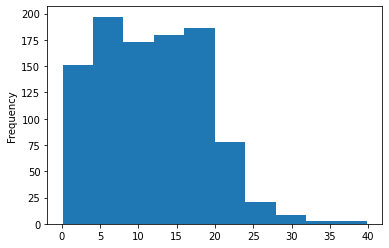

In [ ]:
result.distance.plot(kind='hist')

In [ ]:
random.seed(42)
def associate_home_work(df,number,radius,margin):
  indexes = list(df.index)
  result = []
  try:
    while number > 0:
      home = random.choice(indexes)
      work = find_work(df,radius,margin,home)
      if work != -1:
        result.append({'home':home,'work':work})
        number-=1
  except Exception as e:
    print('Error ',e)
    return pd.DataFrame(result),'not complete dataframe'
  return pd.DataFrame(result)

result = associate_home_work(df,50,3,0.2) #40% with step 3km
result.head()

,home,work
0,poi:12629424,poi:6310331
1,poi:13040215,poi:10656162
2,poi:5449598,poi:10054123
3,poi:21700154,poi:6747054
4,poi:12918651,poi:35472883


In [ ]:
def generate_step():
  #first is the step, the second is max number by step, must not exceed 50
  return random.uniform(1,30),random.randint(30,50)

def generate_seed():
  system = random.randint(0,1)
  if system == 1:
    return None
  else:
    return random.randint(0,100)

def generate_margin(min,max):
  return random.uniform(min,max)

def generate_params():
  params = {
    'seed':generate_seed(),
    'freq':generate_step(),
    'margin':generate_margin(0,1)
  }
  return params

In [ ]:
random.uniform(1,30)

13.901028498934018

In [ ]:
number = 100
#bad solution
#next time, make a statistical inference, so you can cluster well...
#or try to use clustering
#or to brute force optimization
def generate_population_random(data,number):
  df = data.copy()
  finished = False
  pop = []
  print('BEGIN')
  while not finished:
    params = generate_params()
    random.seed(params['seed'])
    step = params['freq'][0]
    number_step = params['freq'][1]
    margin = params['margin']
    pop.append(associate_home_work(df,number_step,step,margin))
    number -= number_step
    if number <= 0:
      print('END')
      break
    print(number)
  return pd.concat(pop)


result = generate_population_random(df,100)
result.head()

In [ ]:
seed = 42
number = 100
steps = [(3,0.3),(10,0.5),(20,0.2)]
margin=[0.0,0.5]
params = {
    'seed':seed,
    'number':number,
    'steps':steps,
    'margin':0.3
}
def generate_population(data,params):
  df = data.copy()
  random.seed(seed)
  number = params['number']
  steps = params['steps']
  margin = params['margin']
  pop = []
  print('BEGIN')
  try:
    for s in steps:
      number_step= int(number * s[1])
      print('Frequency ',s[0],number_step)
      pop.append(associate_home_work(df,number_step,s[0],margin))
    print('END')
    return pd.concat(pop)
  except Exception as e:
    print('FATAL',e)


result = generate_population(df,params)
result.head()

BEGIN
Frequency  3 30
Frequency  10 50
Frequency  20 20
END


,home,work
0,poi:12629424,poi:6310331
1,poi:13040215,poi:10656162
2,poi:5449598,poi:10054123
3,poi:21700154,poi:6751400
4,poi:12918651,poi:35472883


In [ ]:
random.seed(42)
def associate_home_work_better(df,number,step):
  radius, margin = step, 0.1
  result = []
  try:
    # homes = #select_random_pois(number,df)
    # homes = list(homes.index)
    indexes = list(df.index)
    try:
      while number>0:
        home = random.choice(indexes)
        #print(number) need to change here, home then become (lat,lng) 
        #instead of an index
        clustered1 = cluster_by_radius(df,radius,margin,home)
        if clustered1.shape[0] > 0:
          work = select_one_work(clustered1)[0]
          result.append({'home':home,'work':work})
          number-=1
        else:
          print('here!',number)
          continue
        
    except Exception as e:
      print('Error shiimatta ',e)
      return None
      
    print('Success')
    return pd.DataFrame(result)

  except Exception as e:
    print('Error ',e)
    return


associated = associate_home_work_better(df,100,10) 
associated.head()

Success


,home,work
0,5238,843
1,6074,1466
2,1828,382
3,839,5713
4,4467,524


In [ ]:
a = associated.loc[associated.index[1]]
show_home_work(a['home'],a['work'],df)

In [ ]:
def show_result(result,df):
  
  map = folium.Map(location=[36.853685 , 10.323380 ], zoom_start=20,tiles='Stamen Terrain')

  for index,row in result.iterrows():
    home_loc = df.loc[row['home']][['lat','lng']]
    work_loc = df.loc[row['work']][['lat','lng']]
    folium.Marker(location=[home_loc['lat'] , home_loc['lng'] ],
                  icon=folium.Icon(color='green'),
                  popup=df.iloc[row['home'],1]).add_to(map)
    folium.Marker(location=[work_loc['lat'] , work_loc['lng'] ],
                  icon=folium.Icon(color='red'),
                  popup=df.iloc[row['work'],1]).add_to(map)
  return map

show_result(associated,df)

#### An advanced way to generate more POIs for HOME


In [ ]:
import math
def generateRandomPoints(center, radius, count):
  points = []
  for i in range(count):
    points.append(generateRandomPoint(center,radius))
  return points

def generateRandomPoint(center,radius):
  x0 = center['lng'] #lng
  y0 = center['lat'] #lat
  rd = radius / 111300
  u = random.random()
  v = random.random()

  w = rd * math.sqrt(u)
  t = 2 * np.pi * v
  x = w * np.cos(t)
  y = w * np.sin(t)

  xp = x / np.cos(y0)

  return {'lat': y+y0, 'lng': xp+x0}

source = df.loc[associated.index[0]]
randomGeoPoints = generateRandomPoints(source, 100, 10)
randomGeoPoints

[{'lat': 36.747583238104745, 'lng': 10.30895824813418},
 {'lat': 36.747386587807185, 'lng': 10.30784521703073},
 {'lat': 36.74754346423336, 'lng': 10.30893246135855},
 {'lat': 36.74789998887043, 'lng': 10.310599155060595},
 {'lat': 36.747375244426934, 'lng': 10.309561968624859},
 {'lat': 36.747349164552624, 'lng': 10.310219350469795},
 {'lat': 36.74723134771687, 'lng': 10.308273551794853},
 {'lat': 36.7476422377715, 'lng': 10.30956975031947},
 {'lat': 36.74726373730741, 'lng': 10.30815005472838},
 {'lat': 36.74805820604606, 'lng': 10.309242348936387}]

In [ ]:
random.choice(randomGeoPoints)

{'lat': 36.747349164552624, 'lng': 10.310219350469795}

In [ ]:
lst = []
for c in randomGeoPoints:
  lst.append([c['lat'],c['lng']])

def show_folium(lst):
  
  locationlist = lst[:]
  map = folium.Map(location=[36.853685 , 10.323380 ], zoom_start=12,tiles='Stamen Terrain')

  for point in range(0,len(locationlist)):
    print(locationlist[point])
    
    folium.Marker(locationlist[point], icon=folium.Icon(color='green'),popup=str(point)).add_to(map)

  return map

show_folium(lst)